### Notebook used to QC SEA imputed data from Michigan imputation server (MIS) and TopMed imputation server

Allocate computing resources on Slurm cluster for imputation data QC


```bash
$ sdev -m 120 -J jNotebook
$ jupyter-notebook --no-browser --ip=0.0.0.0 --port=8010
```

IMPORTANT: Tested only with kernel version <code>Python 3.6.8</code>

Import required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns
import numpy as np
import os, glob, psutil
from zipfile import ZipFile
import subprocess
import dotenv
import re

Create functions used during script

In [2]:
# Define a function to sort chromosomes as expected by humans (used during plotting)
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

# Functions used to add vertical and horizontal mean/median lines during plotting
def add_mean_horizontal_line(data, var=None, **kws):
    
    # If no variable provided skip adding mean line
    if not var: return
    
    #Calculate mean for each group
    m = np.mean(data[var])
    
    #Get current axis
    ax = plt.gca()
    
    #add line at group mean
    ax.axhline(
        m,
        color='maroon',
        lw=2,
        ls='--'
        )
        
    ax.text(
        0.7, 
        m+0.1 if (m+0.1) < 0.9 else m-0.125,
        f'mean={m:.2f}',
        # transforms positions to range from (0,0) to (1,1)
        transform=ax.transAxes,
        color='maroon',
        fontweight='bold',
        fontsize=8
        )

def add_median_horizontal_line(data, var=None, **kws):
    
    # If no variable provided skip adding median line
    if not var: return
    
    #Calculate median for each group
    m = np.median(data[var])
    
    #Get current axis
    ax = plt.gca()
    
    #add line at group median
    ax.axhline(
        m,
        color='maroon',
        lw=2,
        ls='--'
        )
        
    ax.text(
        0.6,
        m+0.1 if (m+0.1) < 0.9 else m-0.125,
        f'median={m:.2f}',
        # transforms positions to range from (0,0) to (1,1)
        transform=ax.transAxes,
        color='maroon',
        fontweight='bold',
        fontsize=8
        )
    
def add_mean_vertical_line(data, var=None, **kws):
    
    # If no variable provided skip adding mean line
    if not var: return
    
    #Calculate mean for each group
    m = np.mean(data[var])
    
    #Get current axis
    ax = plt.gca()
    
    #add line at group mean
    ax.axvline(
        m,
        color='maroon',
        lw=2,
        ls='--'
        )
        
    ax.text(
        m+0.05 if (m+0.1) < 0.9 else m-0.4,
        0.65,
        f'mean={m:.2f}',
        # transforms positions to range from (0,0) to (1,1)
        transform=ax.transAxes,
        color='maroon',
        fontweight='bold',
        fontsize=8
        )
    
def add_median_vertical_line(data, var=None, **kws):
    
    # If no variable provided skip adding median line
    if not var: return
    
    #Calculate median for each group
    m = np.median(data[var])
    
    #Get current axis
    ax = plt.gca()
    
    #add line at group median
    ax.axvline(
        m,
        color='maroon',
        lw=2,
        ls='--'
        )
        
    ax.text(
        m+0.05 if (m+0.1) < 0.9 else m-0.4,
        0.65,
        f'median={m:.2f}',
        # transforms positions to range from (0,0) to (1,1)
        transform=ax.transAxes,
        color='maroon',
        fontweight='bold',
        fontsize=8
        )



Extract all imputed zip files

In [ ]:
# Loop over topmed folder with zip files extracting only info.gz files
# ZipFile function is too slow to extract large files so we are forced
# to make a system call to unzip directly from OS
dotenv.load_dotenv("./imputed_genotypes/imputation_passwords.env")

for imputation_zip_file in glob.glob( "./imputed_genotypes/*/*/*.zip"):
    print("Extracting file: {0}".format(imputation_zip_file) )
        
    imputation_zip_file_info = {
        "root_folder": imputation_zip_file.split( "/" )[0],
        "imputation_root_folder": imputation_zip_file.split( "/" )[1],
        "imputation_server": imputation_zip_file.split( "/" )[2],
        "genome_build": imputation_zip_file.split( "/" )[3],
        "filename": imputation_zip_file.split( "/" )[4]
    }
    
    password_key = imputation_zip_file_info["imputation_server"] + "_" + imputation_zip_file_info["genome_build"]
    zip_password = os.getenv( password_key )

    zip_files_folder = os.path.dirname( imputation_zip_file )

    # print( "unzip -P " + zip_password + " -d " + zip_files_folder + " " + imputation_zip_file)    
    subprocess.run(
        ["unzip", "-P", zip_password, "-d", zip_files_folder, imputation_zip_file],
        stdout=subprocess.PIPE
    )

Read <code>info.gz</code> files with metrics from imputation

In [3]:
imputation_root_folder = "./imputed_genotypes/"

li = []
n_file = 0

file_list = glob.glob( imputation_root_folder + "/**/" +  "/*.info.gz", recursive = True )

selected_chrs = ["chr19.info.gz", "chr20.info.gz", "chr21.info.gz", "chr22.info.gz", "chrX.info.gz"]

# Read all info.gz files printing memory stats during loading
for current_imputation_file in file_list:

    n_file += 1
    memory_used = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2;
    print( "[{0} of {1}; {2:,.2f} MB] Reading file: {3}".format(n_file, len(file_list), memory_used, current_imputation_file ) )
    
    file_info = current_imputation_file.split( sep = "/" )
    imputation_ref = file_info[2]
    genome_build = file_info[3]
    file_name = file_info[4]
    
    # Skip some chromosomes for testing purposes
    if(file_name not in selected_chrs):
        continue
    
    current_imputation_info = pd.read_table( current_imputation_file )
    current_imputation_info["Reference_Panel"] = imputation_ref
    current_imputation_info["Genome_Build"] = genome_build

    li.append( current_imputation_info )

# Concatenate everything on pandas dataframe named imputation_info
imputation_info = pd.concat(li, axis=0, ignore_index=True)

# Delete li to save memory
del li

# Print memory status
memory_used = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2;
print( "Total memory used during loading: {0:,.2f} MB".format(memory_used) )

[1 of 46; 117.45 MB] Reading file: ./imputed_genotypes/michigan_hrc/hg19/chr19.info.gz
[2 of 46; 273.07 MB] Reading file: ./imputed_genotypes/michigan_hrc/hg19/chr18.info.gz
[3 of 46; 273.07 MB] Reading file: ./imputed_genotypes/michigan_hrc/hg19/chr9.info.gz
[4 of 46; 273.07 MB] Reading file: ./imputed_genotypes/michigan_hrc/hg19/chr17.info.gz
[5 of 46; 273.07 MB] Reading file: ./imputed_genotypes/michigan_hrc/hg19/chr5.info.gz
[6 of 46; 273.32 MB] Reading file: ./imputed_genotypes/michigan_hrc/hg19/chr4.info.gz
[7 of 46; 273.32 MB] Reading file: ./imputed_genotypes/michigan_hrc/hg19/chr16.info.gz
[8 of 46; 273.32 MB] Reading file: ./imputed_genotypes/michigan_hrc/hg19/chr1.info.gz
[9 of 46; 273.32 MB] Reading file: ./imputed_genotypes/michigan_hrc/hg19/chr12.info.gz
[10 of 46; 273.32 MB] Reading file: ./imputed_genotypes/michigan_hrc/hg19/chr15.info.gz
[11 of 46; 273.32 MB] Reading file: ./imputed_genotypes/michigan_hrc/hg19/chr8.info.gz
[12 of 46; 273.32 MB] Reading file: ./imputed_

Create <code>chr</code> and <code>pos</code> atributes in the dataframe

In [4]:
imputation_info_coords = imputation_info.SNP.str.split(":", expand = True)[[0,1]]
imputation_info_coords.columns = ["chr", "pos"]

imputation_info = imputation_info.join( imputation_info_coords )

# Print the first 5 lines
imputation_info.head()

,SNP,REF(0),ALT(1),ALT_Frq,MAF,AvgCall,Rsq,Genotyped,LooRsq,EmpR,EmpRsq,Dose0,Dose1,Reference_Panel,Genome_Build,chr,pos
0,19:89282:C:T,C,T,0.10673,0.10673,0.89327,0.00155,Imputed,-,-,-,-,-,michigan_hrc,hg19,19,89282
1,19:89304:G:A,G,A,0.00000,0.00000,1.00000,0.00000,Imputed,-,-,-,-,-,michigan_hrc,hg19,19,89304
2,19:89309:A:G,A,G,0.00031,0.00031,0.99969,0.00001,Imputed,-,-,-,-,-,michigan_hrc,hg19,19,89309
3,19:90678:G:A,G,A,0.00000,0.00000,1.00000,0.00000,Imputed,-,-,-,-,-,michigan_hrc,hg19,19,90678
4,19:90974:T:C,T,C,0.00051,0.00051,0.99949,0.00001,Imputed,-,-,-,-,-,michigan_hrc,hg19,19,90974


In [5]:
memory_used = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2;
print( "Memory used {0:,.2f} MB".format(memory_used) )

Memory used 22,704.49 MB


Small adjustments on pandas dataframes to enable proper interpretation/plotting

In [6]:
# Standardize chr names to downstream analysis (Info files are different if from hg19 or hg38)
imputation_info["chr"] = imputation_info["chr"].str.replace("^chr","", regex=True)

# Subset only to SNPs that were genotyped and save it on another dataframe
imputation_info_genotyped = imputation_info[ imputation_info.Genotyped == "Genotyped" ]

# Cast numeric variables to enable plotting
imputation_info = imputation_info.astype( { 
        'pos': 'int'
    }
)

print( "Object imputation_info:\n", imputation_info.dtypes , "\n" )

imputation_info_genotyped = imputation_info_genotyped.astype( { 
        'LooRsq': 'float', 
        'EmpR': 'float', 
        'EmpRsq': 'float',
        'Dose0': 'float',
        'Dose1': 'float',
        'pos': 'int'
    }
)

print( "Object imputation_info_genotyped:\n", imputation_info_genotyped.dtypes , "\n" )

Object imputation_info:
 SNP                 object
REF(0)              object
ALT(1)              object
ALT_Frq            float64
MAF                float64
AvgCall            float64
Rsq                float64
Genotyped           object
LooRsq              object
EmpR                object
EmpRsq              object
Dose0               object
Dose1               object
Reference_Panel     object
Genome_Build        object
chr                 object
pos                  int64
dtype: object 

Object imputation_info_genotyped:
 SNP                 object
REF(0)              object
ALT(1)              object
ALT_Frq            float64
MAF                float64
AvgCall            float64
Rsq                float64
Genotyped           object
LooRsq             float64
EmpR               float64
EmpRsq             float64
Dose0              float64
Dose1              float64
Reference_Panel     object
Genome_Build        object
chr                 object
pos                  int64
dtype:

In [7]:
maf_categories = [0, 0.0001, 0.001, 0.05, 0.5]

imputation_info["MAF_categories"] = pd.cut(
    imputation_info.MAF,
    maf_categories,
    include_lowest=True
    )

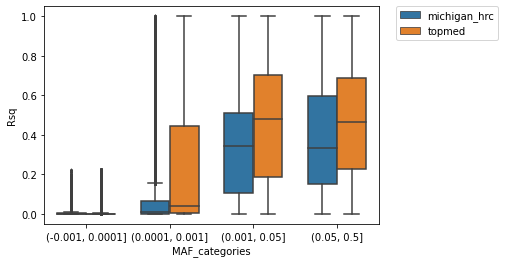

In [8]:
sns.boxplot(
    x = "MAF_categories",
    y = "Rsq",
    data = imputation_info,
    hue="Reference_Panel",
    hue_order=['michigan_hrc','topmed'],
    width=0.7,
    fliersize=2
    )

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
sns.stripplot(
    x = "MAF_categories",
    y = "Rsq",
    data = imputation_info,
    hue="Reference_Panel",
    hue_order=['michigan_hrc','topmed'],
    size = 1,
    dodge=True
    )

# Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
# ax = sns.boxplot(x="tip", y="day", data=tips, whis=np.inf)

ax = sns.boxplot(
    x = "MAF_categories",
    y = "Rsq",
    data = imputation_info,
    hue="Reference_Panel",
    hue_order=['michigan_hrc','topmed'],
    size = 1,
    dodge=True
    )

ax = sns.stripplot(
    x = "MAF_categories",
    y = "Rsq",
    data = imputation_info,
    hue="Reference_Panel",
    hue_order=['michigan_hrc','topmed'],
    size = 1,
    dodge=True
    )

In [ ]:
sns.relplot(
    x = "MAF_categories",
    y = "Rsq",
    data = imputation_info_subset,
    kind='line',
    hue="Reference_Panel",
    hue_order=['michigan_hrc','topmed']
    )

# Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [9]:
imputation_info_subset = imputation_info.sample(100000)
imputation_info_subset["MAF_categories"] = imputation_info_subset["MAF_categories"].astype(str)

In [ ]:
imputation_info_subset.dtypes

In [ ]:
imputation_info_subset["MAF_categories"].head

No handles with labels found to put in legend.


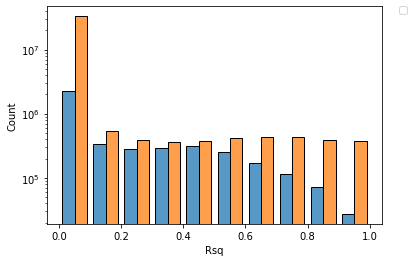

In [11]:
g = sns.histplot(
    x = "Rsq",
    binwidth=0.1,
    binrange=(0,1),
    data = imputation_info,
#     data = imputation_info.sample(1000),
    hue = "Reference_Panel",
    hue_order=['michigan_hrc','topmed'],
    multiple='dodge',
    shrink=0.8
    )

g.set_yscale("log")

# # Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
sns.set_style('white')

# Define which attribute to use on y axis: Rsq
y_atribute = "Rsq"

g = sns.FacetGrid(
    imputation_info,
    col="chr",
    col_wrap=4,
    col_order=natural_sort( imputation_info.chr.unique() ),
    hue="Genotyped",
    sharex=False
    )
g.map_dataframe(
    sns.scatterplot,
    x="pos",
    y=y_atribute,
    alpha=0.4,
    s=6
    )

g.map_dataframe(
    add_median_horizontal_line, 
    var=y_atribute
    )
g.set_axis_labels(
    "chromosome position",
    y_atribute
    )

# Add a general title to the figure
g.fig.subplots_adjust(top=0.90)
g.fig.suptitle( "Genotyped and imputed SNPs from Michigan HRC hg19 (N={0:,})".format( len(imputation_info) ) )

# Edit title for the subplots
imputation_info_counts_by_chr = imputation_info["chr"].value_counts()
g.set_titles( col_template="{col_name}" )
for subfig in g.axes:
    chr_id = str( subfig.get_title() )
    number_of_snps = imputation_info_counts_by_chr[ chr_id ]
    subfig.set_title("chr{0} (N={1:,})".format(chr_id, number_of_snps) )

# format the labels with f-strings
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f'{round(x/1000000)}M'))
    
g.add_legend()

In [ ]:
# sns.set_style('white')

# # Define which attribute to use on y axis: Rsq, LooRsq, EmpR, EmpRsq, Dose0, Dose1
# y_atribute = "LooRsq"

# g = sns.FacetGrid(
#     imputation_info_genotyped,
# #   row="Reference_Panel",
#     col="chr",
#     col_wrap=4,
#     col_order=natural_sort( imputation_info_genotyped.chr.unique() ),
#     sharex=False
#     )
# g.map_dataframe(
#     sns.scatterplot,
#     x="pos",
#     y=y_atribute,
#     alpha=0.5,
#     s=10
#     )

# g.map_dataframe(
#     add_median_horizontal_line, 
#     var=y_atribute
#     )
# g.set_axis_labels(
#     "chromosome position",
#     y_atribute
#     )

# # Add a general title to the figure
# g.fig.subplots_adjust(top=0.90)
# g.fig.suptitle( "Genotyped SNPs (N={0:,})".format( len(imputation_info_genotyped) ) )

# # Edit title for the subplots
# imputation_info_genotyped_counts_by_chr = imputation_info_genotyped["chr"].value_counts()
# g.set_titles( col_template="{col_name}" )
# for subfig in g.axes:
#     chr_id = str( subfig.get_title() )
#     number_of_snps = imputation_info_genotyped_counts_by_chr[ chr_id ]
#     subfig.set_title("chr{0} (N={1:,})".format(chr_id, number_of_snps) )

# # format the labels with f-strings
# for ax in g.axes.flat:
#     ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f'{round(x/1000000)}M'))

In [ ]:
sns.set_style('white')

# Define which attribute to use on y axis: Rsq, LooRsq, EmpR, EmpRsq, Dose0, Dose1
y_atribute = "LooRsq"

g = sns.FacetGrid(
    imputation_info_genotyped,
    row="chr",
    col="Reference_Panel",
#     col_wrap=4,
#     col_order=natural_sort( imputation_info_genotyped.chr.unique() ),
    sharex=False
    )
g.map_dataframe(
    sns.scatterplot,
    x="pos",
    y=y_atribute,
    alpha=0.5,
    s=10
    )

g.map_dataframe(
    add_median_horizontal_line, 
    var=y_atribute
    )
g.set_axis_labels(
    "chromosome position",
    y_atribute
    )

# Add a general title to the figure
g.fig.subplots_adjust(top=0.90)
g.fig.suptitle( "Genotyped SNPs (N={0:,})".format( len(imputation_info_genotyped) ) )

# Edit title for the subplots
imputation_info_genotyped_counts_by_chr = imputation_info_genotyped["chr"].value_counts()
g.set_titles( col_template="{col_name}" )
for subfig in g.axes:
    chr_id = str( subfig.get_title() )
    number_of_snps = imputation_info_genotyped_counts_by_chr[ chr_id ]
    subfig.set_title("chr{0} (N={1:,})".format(chr_id, number_of_snps) )

# format the labels with f-strings
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f'{round(x/1000000)}M'))

In [ ]:
maf_categories = [0, 0.0001, 0.01, 0.05, 0.5]

imputation_info["MAF_categories"] = pd.cut(
    imputation_info.MAF,
    maf_categories
    ).astype(str)

# median_rsq_by_maf_tmp = imputation_info.groupby("MAF_categories")["Rsq"].median()

# median_rsq_by_maf = pd.DataFrame(
#     {
#     "MAF_categories": median_rsq_by_maf_tmp.index.astype(str),
#     "Median_observed_imput_rsq": median_rsq_by_maf_tmp.values
#     }
# )

# median_rsq_by_maf.head()

sns.lineplot(
    x = "MAF_categories",
    y = "Rsq",
    data = imputation_info,
    color = "maroon"
    )

In [ ]:
sns.set_style('white')

g = sns.FacetGrid(
    imputation_info,
    col="chr",
    col_wrap=4,
    col_order=natural_sort( imputation_info.chr.unique() ),
    hue="Genotyped",
    sharex=False
    )
g.map_dataframe(
    sns.histplot,
    x="Rsq",
    binwidth=0.1,
    binrange=(0,1)
    )

g.map_dataframe(
    add_median_vertical_line, 
    var="Rsq"
    )

# Add a general title to the figure
g.fig.subplots_adjust(top=0.90)
g.fig.suptitle( "Genotyped and imputed SNPs from Michigan HRC hg19 (N={0:,})".format( len(imputation_info) ) )

# Edit title for the subplots
imputation_info_counts_by_chr = imputation_info["chr"].value_counts()
g.set_titles( col_template="{col_name}" )
for subfig in g.axes:
    chr_id = str( subfig.get_title() )
    number_of_snps = imputation_info_counts_by_chr[ chr_id ]
    subfig.set_title("chr{0} (N={1:,})".format(chr_id, number_of_snps) )
    
# format the labels with f-strings
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f'{round(x/1000)}k'))
    # ax.set_yscale("log")
    
# g.set_yscale("log")
g.add_legend()

In [ ]:
maf_categories = [0, 0.0001, 0.01, 0.05, 0.5]

imputation_info["MAF_categories"] = pd.cut(
    imputation_info.MAF,
    maf_categories
    )

median_rsq_by_maf_tmp = imputation_info.groupby("MAF_categories")["Rsq"].median()

median_rsq_by_maf = pd.DataFrame(
    {
    "MAF_categories": median_rsq_by_maf_tmp.index.astype(str),
    "Median_observed_imput_rsq": median_rsq_by_maf_tmp.values
    }
)

g = sns.lineplot(
    x = "MAF_categories",
    y = "Median_observed_imput_rsq",
    data = median_rsq_by_maf,
    color = "maroon"
    )

g.set_title( "Genotyped and imputed SNPs from Michigan HRC hg19\n(N={0:,})".format( len(imputation_info) ) )
g.set(
    xlabel = "Reference panel Minor Allele Frequency",
    ylabel = "Median Observed Imput Rsq"
)

In [ ]:
    # sns.histplot,
    # x="Rsq",
    # bins=10

sns.set_style('white')

sns.histplot(
    x = "MAF",
    y = "Rsq",
    # hue="maf_categories",
    data = imputation_info,
    bins = [0,0.0001,0.01,0.05,0.5]
    # stat='probability',
    # cumulative=True,
    # fill=False,
    # element='step'
)


In [ ]:
# imputation_info["maf_categories"] = pd.cut(
#     imputation_info,
#     [-np.inf, 0.001, 0.1, 0.2, 0.3, np.inf]
#     )

print( imputation_info.groupby("maf_categories")["Rsq"].mean() )

# sns.histplot(
#     x = "Rsq",
#     # y = "Rsq",
#     hue="maf_categories",
#     data = imputation_info
#     # cumulative=True,
#     # kde=True
# )
#     x = "Rsq",
#     data = imputation_info,
#     bins = 10,
#     element='step',
#     col=
#     )


Create a plot of **Rsq** along with the chromosome genomic positions

In [ ]:
# Create scatter plot of genomic positions by estimated r2 (from minimac4 leave one out column)
plt.scatter( 
    x = chr21_genotyped.pos.astype(int), 
    y = chr21_genotyped.LooRsq.astype(float), 
    marker = 'o',
    color='gray',
    s=3,
    alpha=0.75
    )

# Add horizontal line with mean LooRsq
mean_rsq = statistics.mean( chr21_genotyped.LooRsq.astype(float) )
plt.axhline(
    y=mean_rsq, 
    color='red',
    linestyle='--'
    )
plt.text( 
    x = max(chr21_genotyped.pos.astype(int))*0.825,
    y = mean_rsq+0.025,
    s = "Mean R\u00b2 = {:.2f}".format(mean_rsq),
    color='red'
    )

# Adjust labels and axis
plt.title( "chr21 (N = " + str(len(chr21_genotyped)) + ")" )
plt.xlabel("chr21 genomic position")
plt.ylabel("Empirical (Leave-One-Out) R\u00b2")

In [ ]:
# Make a histogram of LooRsq
plt.hist(
  x = chr21_genotyped.LooRsq.astype(float),
  bins = 10,
  color='black',
  alpha = 0.6
  )

# Adjust labels and axis
plt.title( "chr21 (N = " + str(len(chr21_genotyped)) + ")" )
plt.xlabel("Empirical (Leave-One-Out) R\u00b2")
plt.ylabel("Frequency")

In [ ]:
# Get number of passing variants at different RSq levels 
rsq_filter = [0, 0.001, 0.1, 0.2, 0.3]

total = len(chr21.Rsq.astype(float))

for c_rsq in rsq_filter:
    passing = sum ( chr21.Rsq.astype(float) >= c_rsq)
    print ("Passing = {0:,}, filtered= {1:,} \t (RSq threshold = {2:,})".format(passing, total-passing, c_rsq) )

Create a plot of **MAF** by **Mean imputation Rsq** 